# Hierarchical Network Selection Scheme

In [317]:
import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt
from IPython.display import display, Image

##### Functions 
1. Fuzzy Membership Function: User-preferences Weights Calculations
2. AHP Function: Service QoS Weights Calculations
3. Weights Calculations
4. Normalisation Functions  
5. MEW Function: RAT Scores Calculations
6. SAW Function: AP/Cell Scores Calculations
7. RAT Threshold Filter Function
##### Simulation Data
1. Decision Matrix
2. User Preference Weights
3. Service Pair-Wise Comparison Matrices

##### Evaluations
1. Investigating the distribution of the 27 unique users across the RATs for each service
2. Investigating the RAT rankings per service type
3. Investigate the sensitivity of the user preference weights on RAT scores
4. Investigate the sensitivity of the threshold percentage on the number of RATs selected
5. Investigate the load distribution among the APs/cells in each RAT
6. 

___

1\. Fuzzy Membership Function

In [318]:
def computeFuzzyValue(criteria_value, preference, min_value, max_value):
    """
    Calculate the fuzzy membership value for a given criteria.
    
    :param criteria_value: The value of the criteria to evaluate
    :param preference: 'low', 'medium', or 'high'
    :param min_value: The minimum value for the criteria range
    :param max_value: The maximum value for the criteria range
    :return: Membership value between 0 and 1
    """
    
    def low_mf(x, b, c):
        return np.where(x <= b, 1, max(0, (c - x) / (c - b)))
    
    def medium_mf(x, a, b, c):
        return max(0, min((x - a) / (b - a), (c - x) / (c - b)))
    
    def high_mf(x, a, b):
        return np.where(x >= b, 1, max(0, (x - a) / (b - a)))
    
    # Calculate the range
    value_range = max_value - min_value

    preference = preference.lower()
    # Set ratios for a, b, c based on the range
    if preference == 'low':
        b = min_value + 0.25 * value_range
        c = min_value + 0.5 * value_range
        return low_mf(criteria_value, b, c)
    
    elif preference == 'medium':
        a = min_value + 0.25 * value_range
        b = min_value + 0.5 * value_range
        c = min_value + 0.75 * value_range
        return medium_mf(criteria_value, a, b, c)
    
    elif preference == 'high':
        a = min_value + 0.5 * value_range
        b = min_value + 0.75 * value_range
        return high_mf(criteria_value, a, b)
    
    else:
        raise ValueError("Preference must be 'low', 'medium', or 'high'")

In [319]:
def prefToNum(preference: str) -> float:
    """
    Convert preference string to its corresponding numerical value.
    
    Args:
    preference (str): A string representing the QoS preference. 
                      Must be either "Low", "Medium", or "High" (case-insensitive).
    
    Returns:
    float: The numerical value corresponding to the preference.
    
    Raises:
    ValueError: If an invalid preference is provided.
    """
    preference_map = {
        "low": 0.01,
        "medium": 0.50,
        "high": 0.99
    }
    
    normalized_preference = preference.lower()
    
    if normalized_preference not in preference_map:
        raise ValueError("Invalid preference. Must be 'Low', 'Medium', or 'High'.")
    
    return preference_map[normalized_preference]

2\. AHP Function

In [320]:
def computeAHPWeights(matrix):
    """
    Calculate weights and Consistency Index for AHP pairwise comparison matrix.
    
    Args:
    matrix (np.array): Square pairwise comparison matrix
    
    Returns:
    tuple: (weights, consistency_index)
    """
    # Check if the matrix is square
    if matrix.shape[0] != matrix.shape[1]:
        raise ValueError("Matrix must be square")
    
    n = matrix.shape[0]
    
    # Calculate the principal eigenvalue and eigenvector
    eigenvalues, eigenvectors = np.linalg.eig(matrix)
    max_index = np.argmax(eigenvalues)
    max_eigenvalue = eigenvalues[max_index].real
    eigenvector = eigenvectors[:, max_index].real
    
    # Normalize the eigenvector to get the weights
    weights = eigenvector / np.sum(eigenvector)
    #print("Weights:", weights)
    # Calculate the Consistency Index
    ci = (max_eigenvalue - n) / (n - 1)
    
    # Calculate the Random Index
    ri_values = {1: 0, 2: 0, 3: 0.58, 4: 0.9, 5: 1.12, 6: 1.24, 7: 1.32, 8: 1.41, 9: 1.45, 10: 1.49}
    ri = ri_values.get(n, 1.49)  # Use 1.49 for n > 10
    
    # Calculate the Consistency Ratio
    cr = ci / ri if ri != 0 else 0
    if cr > 0.1:
        raise ValueError(f"Not Consistent! cr={cr}")
    
    return weights

3\. Normalisation Functions

In [321]:
def sqrtNormalize(matrix, criteria_types):
    """
    Normalize the matrix using square root normalization,
    accounting for upward and downward criteria.
    
    :param matrix: numpy array of shape (n_rats, n_criteria)
    :param criteria_types: list of strings, either 'up' or 'down' for each criterion
    :return: normalized matrix
    """
    normalized = np.zeros_like(matrix, dtype=float)
    
    for j in range(matrix.shape[1]):
        if criteria_types[j] == 'up':
            normalized[:, j] = matrix[:, j] / np.sqrt(np.sum(matrix[:, j]**2))
        elif criteria_types[j] == 'down':
            normalized[:, j] = 1 - (matrix[:, j] / np.sqrt(np.sum(matrix[:, j]**2)))
        else:
            raise ValueError(f"Invalid criterion type: {criteria_types[j]}. Must be 'up' or 'down'.")
    
    return normalized

In [322]:
def minmaxNormalize(matrix, criteria_types):
    """
    Normalize RAT criteria matrix using Max-Min function.
    
    :param matrix: 2D numpy array where each row represents a RAT and each column a criterion
    :param criteria_types: List of strings ('up' or 'down') indicating whether each criterion is upward or downward
    :return: Normalized matrix
    """
    normalized = np.zeros_like(matrix, dtype=float)
    
    for j in range(matrix.shape[1]):
        column = matrix[:, j]
        col_min, col_max = np.min(column), np.max(column)
        if col_min == col_max:
            col_min -= 1
        
        if criteria_types[j] == 'up':
            normalized[:, j] = 1 - abs(column - col_max) / (col_max - col_min)
        elif criteria_types[j] == 'down':
            normalized[:, j] = 1 - abs(column - col_min) / (col_max - col_min)
        else:
            raise ValueError(f"Invalid criterion type for column {j}. Must be 'up' or 'down'.")
    
    return normalized

4\. Final Weights Calculation Functions

*4.1 RAT Selection Weights*

In [323]:
def userPrefWeights(userpref_criteria, user_prefs):
    """
    Calculate the weights for a [single] user's preferences.
    single user single alternative.
    
    :param userpref_criteria: [power, cost]
        numpy array of shape (n_userpreference_criteria,) containing the [single alternative] criteria values 
    :param user_prefs: [qos, power, cost] 
        numpy array of shape (n_userpreference_criteria,) containing the user's preferences 
    
    :return: numpy array of shape (n_userpreference_weights,) containing the weights for the user's preferences
    """
    dm_df = pd.read_csv("simulation_data/decision_matrix.csv",header = None) # RAT+AP/Cell decision matrix dataframe

    # extract power and cost min and max values for fuzzy value computation
    P_max = np.max(dm_df[1][1:6].values.astype(np.float64)) # power max value
    P_min = np.min(dm_df[1][1:6].values.astype(np.float64)) # power min value
    C_max = np.max(dm_df[2][1:6].values.astype(np.float64)) # cost max value
    C_min = np.min(dm_df[2][1:6].values.astype(np.float64)) # cost min value

    userpref_weights = np.zeros(user_prefs.shape[0])
    userpref_weights[0] = prefToNum(user_prefs[0])
    userpref_weights[1] = computeFuzzyValue(userpref_criteria[0],user_prefs[1],P_min,P_max)
    userpref_weights[2] = computeFuzzyValue(userpref_criteria[1],user_prefs[2],C_min,C_max) 
    
    return userpref_weights 

In [324]:
def usersPrefWeights(criteria, users_prefs):
    """weights
    Calculate the weights for all users' preferences.

    :param criteria: [power, cost, delay, jitter, packet loss, throughput] 
        numpy array of shape (n_criteria,) containing the criteria values
    :param users_prefs: numpy array of shape (n_users, n_criteria) containing the users' preferences
    :return: numpy array of shape (n_users, n_criteria) containing the weights for the users' preferences
    """
    userspref_weights = np.zeros_like(users_prefs)
    
    for i in range(users_prefs.shape[0]):
        userspref_weights[i] = userPrefWeights(criteria[:2],users_prefs[i])
    return userspref_weights 

In [325]:
def combineWeights(user_weights, service_weights):
    """
    Combine user and service weights.

    :param user_weights: [qos, power, cost] 
            numpy array of shape (n_userpreference_criteria) containing the user weights
    :param service_weights: [D, J, L, T]
            numpy array of shape (n_service_criteria) containing the service weights
    :return: numpy array of shape (n_users + n_services, n_criteria) containing
                the combined weights for the user and service
    """
    qos = user_weights[0] # qos criteria weight
    powerncost = user_weights[1:] # power and cost criteria weights

    norm_powerncost = powerncost if (np.sum(powerncost)) <= 0 else powerncost/np.sum(powerncost)
    
    return np.concatenate((norm_powerncost * (1 - qos) , service_weights * qos))

In [326]:
def combineAllServiceWeights(criteria, users_prefs, services_weights):
    """
    Combined weights for all users per service.

    :param criteria: [power, cost, delay, jitter, packet loss, throughput] 
        numpy array of shape (n_criteria,) containing the criteria values
    :param users_prefs: numpy array of shape (n_users, n_userpreference_criteria) containing the users' preferences
    :param services_weights: numpy array of shape (n_services, n_service_criteria) containing the services' weights
    :return: numpy array of shape (n_users, n_services, n_criteria) containing the combined weights for all users and services
    """
    no_services = services_weights.shape[0] # 4
    no_criteria = criteria.shape[0] # 6
    no_users = users_prefs.shape[0] # 27

    #weights = np.zeros((27,4,6))
    weights = np.zeros((no_users, no_services, no_criteria))
    userpref_criteria = criteria[:2] # power and cost

    usersprefs_weights = usersPrefWeights(userpref_criteria, users_prefs) # 27x3 matrix of weights
    for i in range(no_users):
        for j in range(no_services):
            weights[i][j] = combineWeights(usersprefs_weights[i],services_weights[j])
    return weights # comprehensive weights for each user per service 

In [327]:
def combineAllRATWeights(matrix, users_prefs, services_weights, service):
    no_users = users_prefs.shape[0] # 27
    no_of_RATs = matrix.shape[0] # 5
    no_of_criteria = matrix.shape[1] # 6
    
    rat_user_weights =  np.zeros((no_of_RATs,no_users,no_of_criteria))

    for i in range(5):# for each RAT compute the user weights for each user 5x27    
        rat_user_weights[i] = combineAllServiceWeights(matrix[i],users_prefs,services_weights)[:, service, :] # service 1 at index 0
       
    return rat_user_weights # 5x27x6

*4.2 AP/Cell Selection Weights*

In [328]:
def randomSINR(min = 0, max = 40):
    return round(np.random.uniform(min, max), 1)

def randomWeights(decision_matrix):
    weights = np.random.rand(decision_matrix.shape[1])
    return weights

def getConstCols(matrix):
  """
  Identifies constant columns in a matrix.

  Args:
    matrix: A NumPy array.

  Returns:
    A list of column indices that have constant values.
  """

  const_columns = []
  for col_idx in range(matrix.shape[1]):
    if np.all(matrix[:, col_idx] == matrix[0, col_idx]):
      const_columns.append(col_idx)
  return const_columns

def criticWeighting(decision_matrix):
    """
    Calculate the CRITIC-based weights for criteria in a decision matrix.

    Parameters:
    decision_matrix (numpy.ndarray): Matrix where each row is an alternative and each column is a criterion.

    Returns:
    numpy.ndarray: Array of weights for each criterion.
    """
    # Step 1: Normalize the decision matrix
    max_values = decision_matrix.max(axis=0)
    #print(max_values)
    max_values[max_values == 0] = 1  # Avoid division by zero
    #print(max_values)
    normalized_matrix = decision_matrix /max_values
    #print(normalized_matrix)
    const_cols = getConstCols(normalized_matrix)
    
    # To avoid division by zero, replace constant columns with random values
    for col in const_cols:
        normalized_matrix[:, col] = np.random.rand(normalized_matrix.shape[0]) 
        
    
    # Step 2: Calculate the standard deviation for each criterion
    std_devs = np.std(normalized_matrix, axis=0)
    
    # Correcting the std deviation for constant columns
    for col in const_cols:
        std_devs[col] = 0 # the std value for constant values is 0
    
    # Step 3: Calculate the correlation matrix between criteria
    correlation_matrix = np.corrcoef(normalized_matrix, rowvar=False)
    #print(correlation_matrix)
    
    # correcting the correlation matrix for constant columns
    for col in const_cols:
        correlation_matrix[col] = 0
        correlation_matrix[:, col] = 0
    

    #print(correlation_matrix)
    # Step 4: Calculate the degree of conflict for each criterion
    conflict = 1 - correlation_matrix
    conflict_sum = conflict.sum(axis=1)  # Sum across each row (for each criterion)

    # Step 5: Calculate the information measure for each criterion (std_devs * conflict_sum)
    information_measure = std_devs * conflict_sum

    # Step 6: Normalize the information measure to get the final weights
    weights = information_measure / information_measure.sum()

    return weights

def entropyWeighting(decision_matrix):
    """
    Calculate the entropy-based weights for criteria in a decision matrix.

    Parameters:
    decision_matrix (numpy.ndarray): Matrix where each row is an alternative and each column is a criterion.

    Returns:
    numpy.ndarray: Array of weights for each criterion.
    """
    # Step 1: Normalize the decision matrix
    normalized_matrix = decision_matrix / decision_matrix.sum(axis=0)
    
    # Step 2: Calculate the entropy for each criterion
    # Small epsilon to avoid log(0) error
    epsilon = 1e-12
    n, m = decision_matrix.shape
    k = 1 / np.log(n)
    
    # Calculate the entropy for each criterion
    entropy = -k * (normalized_matrix * np.log(normalized_matrix + epsilon)).sum(axis=0)
    
    # Step 3: Calculate the degree of divergence (1 - entropy)
    divergence = 1 - entropy
    
    # Step 4: Calculate the weights for each criterion
    weights = divergence / divergence.sum()
    
    return weights

5\. MEW Function

In [329]:
def computeMEW(decision_matrix, weights):
    """
    Calculate scores using the Multiple Exponen Weighted (MEW) method.
    
    Parameters:
    decision_matrix (numpy.ndarray): A normalized decision matrix where rows represent alternatives and columns represent criteria.
    weights (numpy.ndarray): An array of weights for each criterion.
    
    Returns:
    numpy.ndarray: An array of MEW scores for each alternative.
    """
    
    # Ensure inputs are numpy arrays
    decision_matrix = np.array(decision_matrix)
    weights = np.array(weights)
    
    # Check if the number of weights matches the number of criteria
    if decision_matrix.shape[1] != weights.shape[0]:
        raise ValueError("The number of weights must match the number of criteria (columns) in the decision matrix.")
    
    # Calculate MEW scores
    weighted_matrix = np.power(decision_matrix, weights)
    mew_scores = np.prod(weighted_matrix, axis=1)
    
    return mew_scores

In [330]:
def modifiedMEW(decision_matrix, weights_matrix):
    """
    Calculate scores using the Multiple Exponential Weighted (MEW) method with individual weights for each alternative.
    
    Parameters:
    decision_matrix (numpy.ndarray): A normalized decision matrix where rows represent alternatives and columns represent criteria.
    weights_matrix (numpy.ndarray): A matrix of weights where each row corresponds to weights for the respective alternative.
    
    Returns:
    numpy.ndarray: An array of MEW scores for each alternative.
    """
    
    # Ensure inputs are numpy arrays
    decision_matrix = np.array(decision_matrix)
    weights_matrix = np.array(weights_matrix)
    
    # Check if the dimensions of the decision matrix and weights matrix match
    if decision_matrix.shape != weights_matrix.shape:
        raise ValueError("The dimensions of the decision matrix and weights matrix must match.")
    
    # Calculate MEW scores
    weighted_matrix = np.power(decision_matrix, weights_matrix)
    mew_scores = np.prod(weighted_matrix, axis=1)
    
    return mew_scores

6\. SAW Function

In [331]:
def computerSAW(decision_matrix, weights):
    """
    Calculate scores using the Simple Additive Weighting (SAW) method.
    
    Parameters:
    decision_matrix (numpy.ndarray): A normalized decision matrix where rows represent alternatives and columns represent criteria.
    weights (numpy.ndarray): An array of weights for each criterion.
    
    Returns:
    numpy.ndarray: An array of SAW scores for each alternative.
    """
    
    # Ensure inputs are numpy arrays
    decision_matrix = np.array(decision_matrix)
    weights = np.array(weights)
    
    # Check if the number of weights matches the number of criteria
    if decision_matrix.shape[1] != weights.shape[0]:
        raise ValueError("The number of weights must match the number of criteria (columns) in the decision matrix.")
    
    # Calculate SAW scores
    saw_scores = np.sum(decision_matrix * weights, axis=1)
    
    return saw_scores

7\. RAT Threshold Filter Function

In [332]:
def filterRATs(RAT_scores,percentage,RATs):
    """
    Filter the RATs based on a percentage threshold.

    :param RAT_scores: numpy array of shape (n_RATs,) containing the RAT scores
    :param percentage: The percentage threshold to filter the RATs
    :param RATs: list of RATs names
    :return: pandas DataFrame containing the filtered RATs
    """
    threshold = np.max(RAT_scores) * percentage
    
    df = pd.DataFrame(RAT_scores, RATs)
    selected_RATs = df[df[0] > threshold]
    return selected_RATs.T

##### Simulation Data

In [333]:
file_path = "simulation_data"

1\. Decision Matrix

In [334]:
dm_df = pd.read_csv(file_path+"/decision_matrix.csv",header = None) # RAT+AP/Cell decision matrix dataframe

# extract power and cost min and max values for fuzzy value computation
P_max = np.max(dm_df[1][1:6].values.astype(np.float64)) # power max value
P_min = np.min(dm_df[1][1:6].values.astype(np.float64)) # power min value
C_max = np.max(dm_df[2][1:6].values.astype(np.float64)) # cost max value
C_min = np.min(dm_df[2][1:6].values.astype(np.float64)) # cost min value

# extract RAT decision matrix
rat_dm = dm_df.iloc[1:6,1:7].values.astype(np.float64) # RAT decision matrix
RATs = dm_df[0][1:6].values # RAT names
crit_types = dm_df.iloc[6:,1:].values[0] # criteria types

# extract AP/Cell decision matrix
ap_dm = dm_df.iloc[1:6,7:11].values.astype(np.float64)


2\. User Preferences Weights

In [335]:
up_df = pd.read_csv(file_path+"/user_preferences.csv", index_col = 0) # user preferences dataframe
users_prefs = up_df.values # user preferences

3\. Service Pair-Wise Matrices

In [336]:
s_df = pd.read_csv(file_path+"/pairwise_matrices.csv",header = None) # services pairwise comparison matrices dataframe

s = s_df[0].iloc[[0, 7, 14, 21]].values # service names

s_df.dropna(inplace = True) # drop NaN values

s_weights = np.zeros((4,4)) # 4 services, 4 criteria

rows_per_matrix = len(s_df) // 4 

for i in range(s_weights.shape[0]):
    df_service = s_df.iloc[rows_per_matrix * i : (rows_per_matrix * (i+1))].iloc[1:5,1:5] # if i<3 else 0
    s_weights[i] = computeAHPWeights(df_service.values.astype(np.float64))


##### Evaluation

Constants

In [360]:
norm_rat_dm = sqrtNormalize(rat_dm, crit_types[:6]) # normalize RAT decision matrix

no_select_rats = rat_dm.shape[0] # 5
no_services = s_weights.shape[0] # 4
no_users = users_prefs.shape[0] # 27
no_criteria = rat_dm.shape[1] # 6

# Charts

label_fs = 12
title_fs = 14


1\. Investigating the RAT rankings per service type

In [361]:
rat_scores = np.zeros((no_services,no_select_rats)) # RAT scores for each service
combined_weights = np.zeros((no_services,no_criteria)) # combined weights for each service
rat_ranks = np.zeros((no_services,no_select_rats), dtype=np.int64) # RAT ranks for each service

userprefs_weights = np.array([1,0,0]) # equal weights for each user preference criteria

for i in range(no_services):
    combined_weights[i] = combineWeights(userprefs_weights,s_weights[i])
    rat_scores[i] = computeMEW(norm_rat_dm, combined_weights[i])
    rat_ranks[i] = np.argsort(np.argsort(-rat_scores[i]))+1


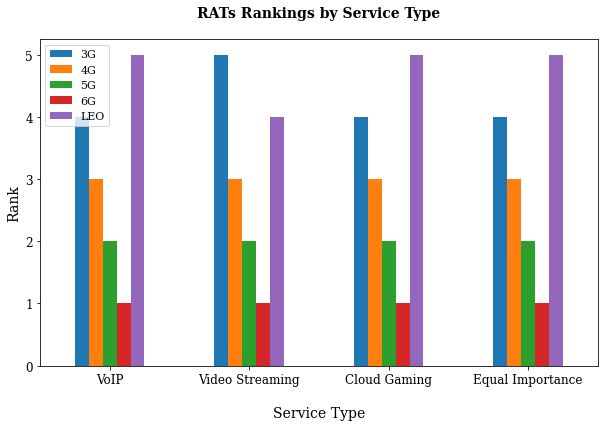

In [362]:
df_rank = pd.DataFrame(rat_ranks, columns=RATs, index=s)
#display(df_rank)
df_rank.plot(kind='bar', figsize=(10, 6))
plt.rc('font', family='serif')
plt.title('RATs Rankings by Service Type\n', fontsize=14, fontweight='bold')
plt.ylabel('Rank', fontsize=14)
plt.xlabel('\nService Type', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=11, loc='upper left')
#plt.show()

# Save the figure
# filename = 'fig_01_rats_rankings.png'
# plt.savefig(filename, dpi=300, bbox_inches='tight')

# # Display the saved image
# display(Image(filename=filename))
plt.show()
# Close the figure to free up memory
plt.close()

2\. Investigating the distribution of the 27 unique users across the RATs for each service

In [364]:
usersperrat = np.zeros((no_services,no_select_rats), dtype=np.int64) # how many times a RAT is ranked 1 by a user for each service

for i in range(s.size):
    scores = np.zeros((no_users,no_select_rats))
    rat_user_weights = combineAllRATWeights(rat_dm, users_prefs, s_weights, i) 

    for j in range(no_users):
        scores[j] = modifiedMEW(norm_rat_dm, rat_user_weights[:,j,:]) # 27x5 
        usersperrat[i] += scores[j]==np.max(scores[j])
        
df_user_rat = pd.DataFrame(usersperrat, columns=RATs, index=s) # RATs ranked 1 by users for each service


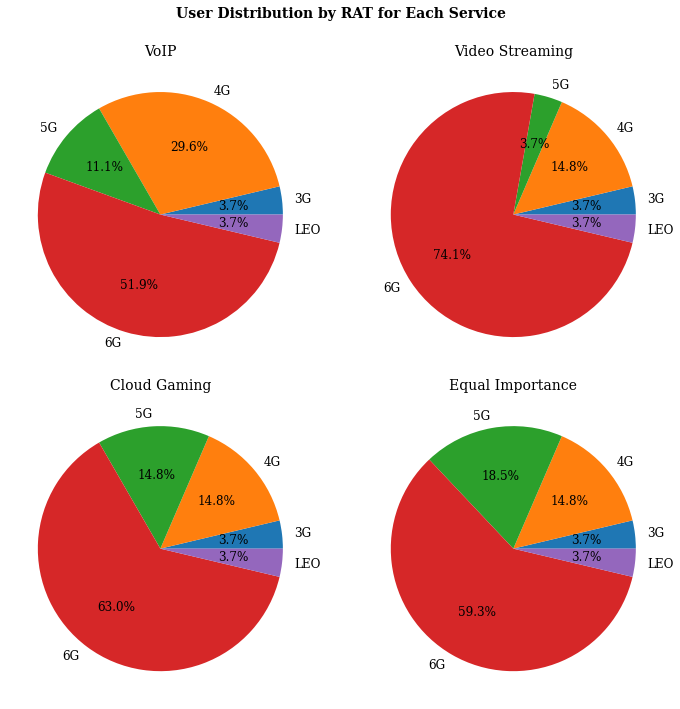

In [365]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

plt.suptitle('User Distribution by RAT for Each Service\n', fontsize=14, fontweight='bold')
for i, service in enumerate(s):
    row = i // 2
    col = i % 2
    ax = axes[row, col]

    # Create the pie chart
    ax.pie(usersperrat[i], labels=RATs, autopct='%1.1f%%', textprops={'fontsize': 12})
    ax.set_title(f'{service}', fontsize=14)


plt.tight_layout()

# Save the figure
# filename = 'fig_02_user_distribution.png'
# plt.savefig(filename, dpi=300, bbox_inches='tight')

# # Display the saved image
# display(Image(filename=filename))
plt.show()
# Close the figure to free up memory
plt.close()

3\. Investigate the sensitivity of the user preference weights on RAT scores

In [342]:
samples = 1000 

weights = np.linspace(0,1,samples)

userpref_criteria = np.array(['QoS','Power Consumption','Cost']) # Q, P, C

rat_scores = np.zeros((userprefs_weights.size,samples,5)) # 1000 samples, 5 RATs, 3 user weights


# for user weight Q, P, C plot a var_weight vs RAT_scores
for i in range(userprefs_weights.size):
    userprefs_weights = np.array([0.1,0.1,0.1]) # equal weights for each user preference criteria, Q, P, C
    for j in range(samples):
        userprefs_weights[i] = weights[j]
        combined_weights = combineWeights(userprefs_weights,s_weights[3]) # service 4: Equal Importance 
        rat_scores[i][j] = computeMEW(norm_rat_dm, combined_weights) #


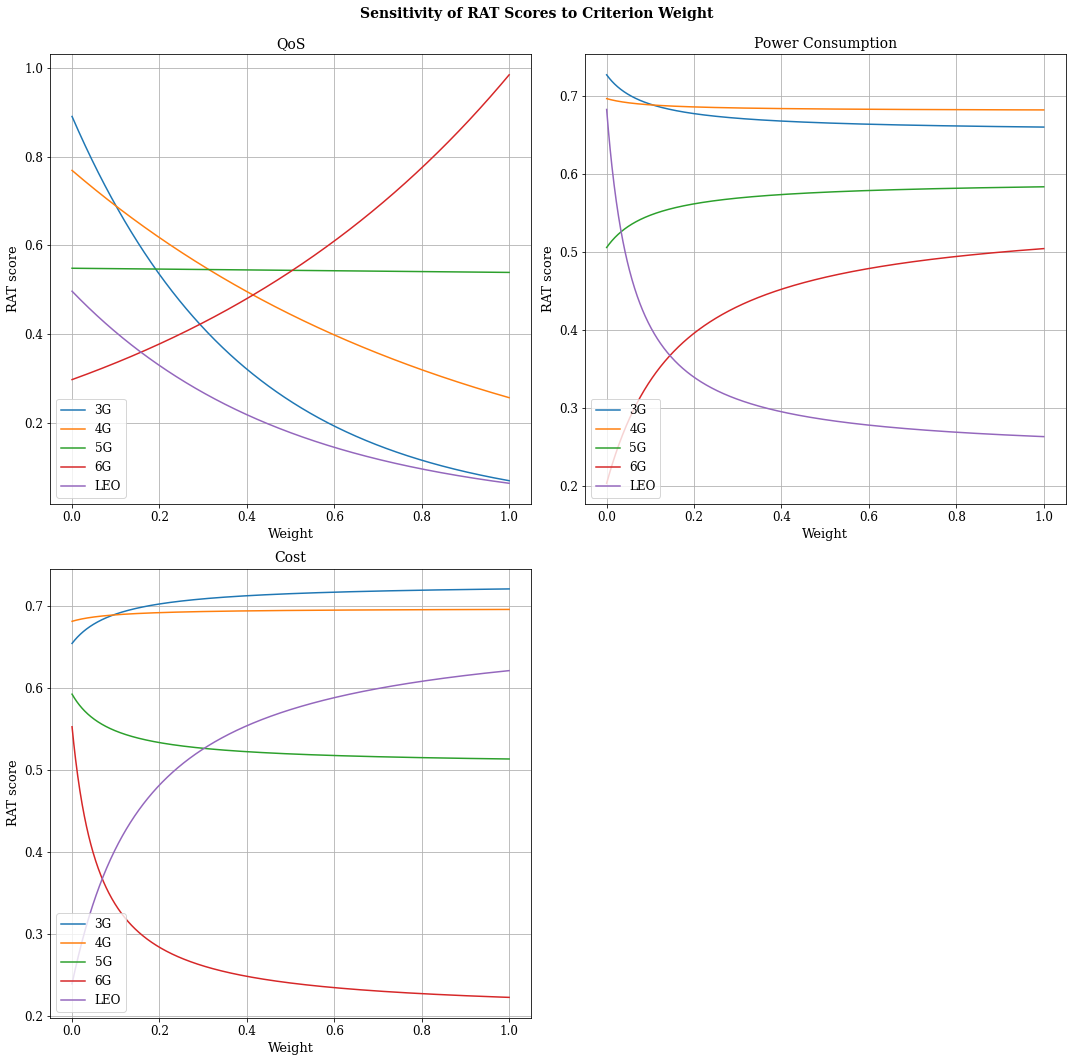

In [343]:
# Set up the plot
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle('Sensitivity of RAT Scores to Criterion Weight\n', fontsize=14, fontweight='bold')

# Flatten the axs array for easier indexing
axs = axs.flatten()


# Plot each criterion
for i, criterion in enumerate(userpref_criteria):
    ax = axs[i]
    for j, rat in enumerate(RATs):
        ax.plot(weights, rat_scores[i, :, j], label=rat)
    
    ax.set_title(f'{criterion}', fontsize=14)
    ax.set_ylabel('RAT score', fontsize=13)
    ax.set_xlabel('Weight', fontsize=13)

   
    ax.tick_params(axis='both', labelsize=12)
    
    ax.legend(fontsize=12)
    ax.grid(True)

# Remove the unused subplot
axs[3].remove()

# Adjust layout and show the plot
plt.tight_layout()

# Save the figure
# filename = 'fig_03_score_sensitivity.png'
# plt.savefig(filename, dpi=300, bbox_inches='tight')

# # Display the saved image
# display(Image(filename=filename))
plt.show()
# Close the figure to free up memory
plt.close()

4\. Investigate the sensitivity of the threshold percentage on the number of RATs selected

In [344]:
userprefs_weights = np.array([0.5,0.5,0.5]) # equal weights for each user preference criteria
percentage = np.linspace(0, 1, 100)

weights = combineWeights(userprefs_weights,s_weights[1]) # service 4: Equal Importance
rat_scores = computeMEW(norm_rat_dm, weights)

no_select_rats = np.zeros(percentage.size)
for i in range(percentage.size):
    no_select_rats[i] = filterRATs(rat_scores,percentage[i],RATs).shape[1]
    

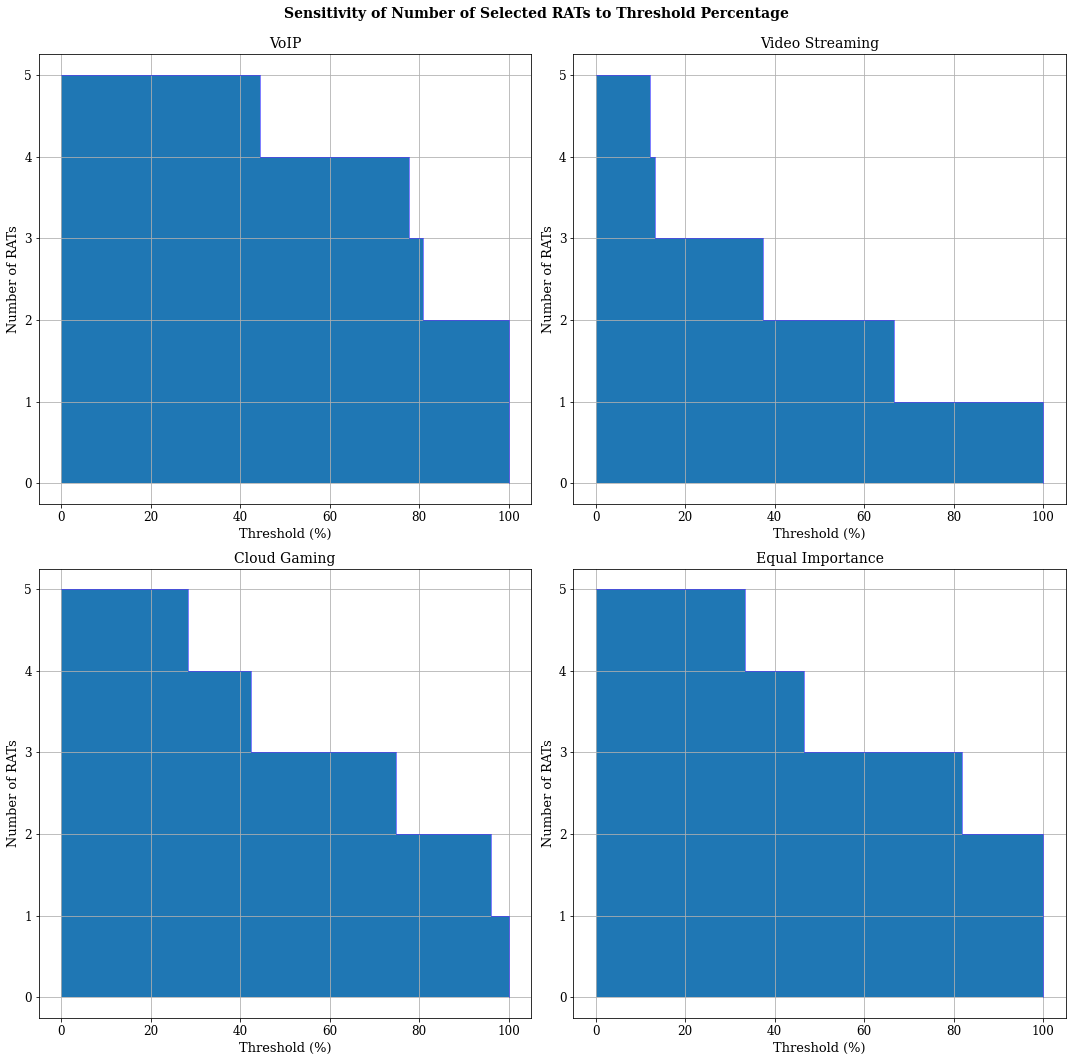

In [345]:
# Create 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle('Sensitivity of Number of Selected RATs to Threshold Percentage\n', fontsize=14, fontweight='bold')

# Flatten the axs array for easier indexing
axs = axs.flatten()

for idx, service in enumerate(s):
    user_weights = np.array([0.5, 0.5, 0.5])  # equal weights for each user preference criteria
    weights = combineWeights(user_weights, s_weights[idx])
    
    # Placeholder for normal_dm_rat, replace with actual data
    #normal_dm_rat = np.random.rand(10, 3)  # Assuming 10 RATs and 3 QoS parameters
    
    rat_scores = computeMEW(norm_rat_dm, weights)
    
    percentage = np.linspace(0, 1, 100)
    no_select_rats = np.zeros(percentage.size)
    
    for i in range(percentage.size):
        no_select_rats[i] = filterRATs(rat_scores, percentage[i], rat_scores).size
    
   # Create step-like data points
    x_steps = np.repeat(percentage, 2)[1:]
    y_steps = np.repeat(no_select_rats, 2)[:-1]
    
    # Add the first and last points to close the shape
    x_steps = np.concatenate(([0], x_steps, [1]))
    y_steps = np.concatenate(([no_select_rats[0]], y_steps, [0]))
    
    axs[idx].tick_params(axis='both', which='major', labelsize=12)

    axs[idx].fill_between(x_steps*100, y_steps, step="pre" ) 
    axs[idx].plot(x_steps*100, y_steps, color='blue', linewidth=0.5, drawstyle='steps-post')
    axs[idx].set_xlabel('Threshold (%)', fontsize=13)
    axs[idx].set_ylabel('Number of RATs', fontsize=13)
    axs[idx].set_title(f'{service}', fontsize=14)
    axs[idx].grid(True)


plt.tight_layout()

# Save the figure
# filename = 'fig_04_filter_sensitivity.png'
# plt.savefig(filename, dpi=300, bbox_inches='tight')

# # Display the saved image
# display(Image(filename=filename))
plt.show()
# Close the figure to free up memory
plt.close()



5\. Investigate the load distribution among the APs/cells in each RAT


,Load
3G,124
4G,109
5G,205
6G,63
LEO,499


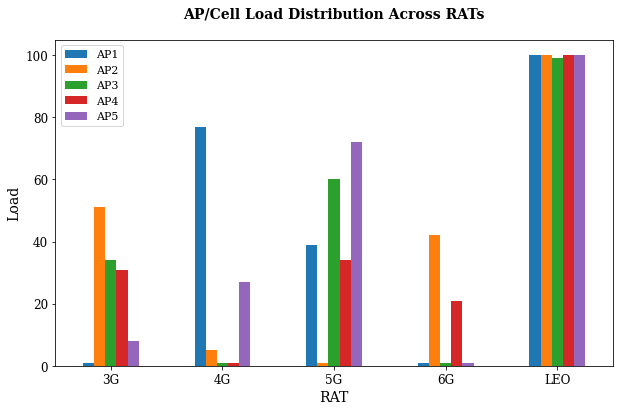

In [348]:
# number of AP/BSs per RAT
M  = 5
# number of simultaneous connections per UE
MC = 10
# number of users
U = 100

selected_rats = filterRATs(rat_scores,0.0,RATs).columns # equal importance RAT scores
no_select_rats = selected_rats.size

# Create a matrix of AP/BS criteria values for each RAT

aps = np.zeros((no_select_rats, M, ap_dm.shape[1]))
all_aps = np.zeros((no_select_rats*M, ap_dm.shape[1]))
cell_nos = np.ones(no_select_rats*M, dtype=np.int64)
modified_AP_matrix = np.zeros((no_select_rats,M))

rat_ap = []
ap_names = []

# initial criteria values for the APs decision matrix 

for i in range(no_select_rats):
    rat = selected_rats[i]
    selected_row = dm_df[dm_df.iloc[:, 0] == rat].iloc[0][7:].values.astype(np.float64)
    rat_ap += [rat] * M
    for j in range(M):
        selected_row[2] = randomSINR() # 
        aps[i, j] = selected_row
        all_aps[j+i*M] = selected_row
        cell_nos[j+i*M] = j+1
        


# Create a dictionary to store the number of users per RAT
usersperrat = {rat: 0 for rat in selected_rats}

for i in range(U):
    normal_ap = minmaxNormalize(all_aps, crit_types[6:])
    weights = criticWeighting(all_aps)
    ap_scores = computerSAW(normal_ap,weights)

    df = pd.DataFrame(list(zip(cell_nos,ap_scores)),index=rat_ap)
    ap_ranks = df.sort_values(by=1, ascending=False)

    # updating the load criteria on the AP matrix after selection
    for j in range(MC): # top C AP are selected
        rat = ap_ranks.iloc[j].name
        rat_index = np.where(selected_rats == rat)[0][0]
        ap_index = ap_ranks.iloc[j].values[0].astype(np.int64) - 1

        #update the load criteria
        all_aps[ap_index + rat_index*M][0] += 1 
        usersperrat[rat] += 1

# create a list of AP names
for i in range(M):
    ap_names.append(f'AP{i+1}')

df_loadperaprat = pd.DataFrame(all_aps[:,0].reshape(M,no_select_rats) , columns = ap_names,index=selected_rats)
df_load = pd.DataFrame(usersperrat, index=['Load']).T
display(df_load)


small_value = 1
df_plot = df_loadperaprat.replace(0, small_value)



df_plot.plot(kind='bar', figsize=(10, 6))
plt.title('AP/Cell Load Distribution Across RATs\n', fontsize=14, fontweight='bold')
plt.ylabel('Load', fontsize=14)
plt.xlabel('RAT', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(rotation=0, fontsize=12)
plt.legend(fontsize=11)


# Save the figure
# filename = 'fig_05_load_distribution.png'
# plt.savefig(filename, dpi=300, bbox_inches='tight')

# # Display the saved image
# display(Image(filename=filename))
plt.show()
# Close the figure to free up memory
plt.close()


6\. Investigate the change in load distribution as number of users increase

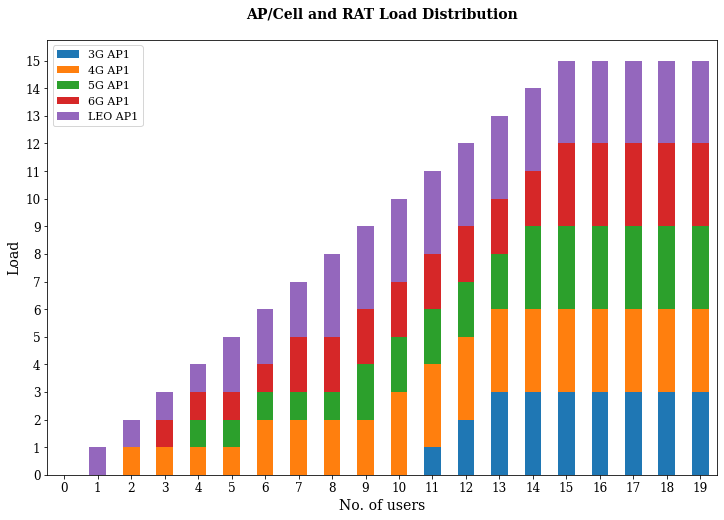

In [349]:
# number of AP/BSs per RAT
M  = 1
# multi-connectivity
MC = 1
# cell capacity
CC = 3
# number of users
U = 20

selected_rats = filterRATs(rat_scores,0.0,RATs).columns
no_select_rats = selected_rats.size

# Create a matrix of AP/BS criteria values for each RAT

aps = np.zeros((no_select_rats, M, ap_dm.shape[1]))
all_aps = np.zeros((no_select_rats*M, ap_dm.shape[1]))
cell_nos = np.ones(no_select_rats*M, dtype=np.int64)
modified_AP_matrix = np.zeros((no_select_rats,M))

rat_ap = []
cell_ids = []

# initial criteria values for the APs decision matrix 
      
for i in range(no_select_rats):
    rat = selected_rats[i]
    selected_row = dm_df[dm_df.iloc[:, 0] == rat].iloc[0][7:].values.astype(np.float64)
    rat_ap += [rat] * M
    for j in range(M):
        selected_row[2] = randomSINR(0,40) 
        aps[i, j] = selected_row
        all_aps[j+i*M] = selected_row
        cell_nos[j+i*M] = j+1
        cell_ids.append(f'{rat} AP{j+1}')


# Create a dictionary to store the number of users per RAT
usersperrat = {rat: 0 for rat in selected_rats}

# Create a matrix to store the AP scores after each user selection
all_ap_scores = np.zeros((U, M*no_select_rats))
ap_loads = np.zeros((U, M*no_select_rats),dtype=np.int64)
load = 0

for i in range(U):
    normal_ap = minmaxNormalize(all_aps, crit_types[6:])
    weights = criticWeighting(all_aps)
    ap_scores = computerSAW(normal_ap,weights)
    
    all_ap_scores[i] = ap_scores
    
    df = pd.DataFrame(list(zip(cell_nos,ap_scores)),index=rat_ap)
    ap_ranks = df.sort_values(by=1, ascending=False)

    ap_loads[i] = all_aps[:,0]

    for j in range(MC): # top C AP are selected
        rat = ap_ranks.iloc[j].name
        rat_index = np.where(selected_rats == rat)[0][0]
        ap_index = ap_ranks.iloc[j].values[0].astype(np.int64) - 1

        #update the load criteria
        if(load < CC * M * no_select_rats):
            if (all_aps[ap_index + rat_index*M][0] < CC):
                all_aps[ap_index + rat_index*M][0] += 1 
                load += 1
            else:
                # eliminate the AP from the selection
                all_aps[ap_index + rat_index*M][1] = 0
                all_aps[ap_index + rat_index*M][2] = 0
                # add to the next best AP
                if(j<MC):
                    rat = ap_ranks.iloc[j+1].name
                    rat_index = np.where(selected_rats == rat)[0][0]
                    ap_index = ap_ranks.iloc[j+1].values[0].astype(np.int64) - 1
                    all_aps[ap_index + (rat_index)*M][0] += 1
                    load += 1


df_load = pd.DataFrame(ap_loads, columns=cell_ids)

df_load.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title("AP/Cell and RAT Load Distribution\n", fontsize=14, fontweight='bold')
plt.yticks(range(0, sum(ap_loads[-1]) + 1), fontsize=12);
plt.xticks(fontsize=12, rotation=0)
plt.ylabel('Load', fontsize=14)
plt.xlabel('No. of users', fontsize=14)
plt.legend(fontsize=11)


# Save the figure
# filename = 'fig_06_load_distribution.png'
# plt.savefig(filename, dpi=300, bbox_inches='tight')

# # Display the saved image
# display(Image(filename=filename))
plt.show()
# Close the figure to free up memory
plt.close()